# Setup

In [1]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

import pandas as pd

tf.__version__

'2.3.0'

In [2]:
from sklearn.model_selection import train_test_split

data = pd.read_csv('./data_labels_mainData.csv')

train_data_big, test_data_big = train_test_split(data, test_size=0.2, random_state=42)
train_data_big, val_data_big = train_test_split(train_data_big, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data_big.shape[0], val_data_big.shape[0], test_data_big.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


In [3]:
# making data set smaller for faster compile

_, train_data = train_test_split(train_data_big, test_size=0.2, random_state=42)
_, test_data = train_test_split(test_data_big, test_size=0.2, random_state=42)
_, val_data = train_test_split(val_data_big, test_size=0.2, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 1188, Val Data: 396, Test Data: 396


In [4]:
# cellType needs to be string
train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

<ipython-input-4-c8097c89ef5b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['cellType'] = train_data['cellType'].astype('str')
<ipython-input-4-c8097c89ef5b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['cellType'] = val_data['cellType'].astype('str')


In [5]:
# learning curve function
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

# Base model setup

In [6]:
import tensorflow as tf
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 1188 validated image filenames belonging to 4 classes.
Found 396 validated image filenames belonging to 4 classes.


### Model1
no tuning just using:
1. HIDDEN_LAYER_DIM = 256
2. no reg
3. no dropout
4. sigmoid activation

Instructions for updating:
Please use Model.fit, which supports generators.


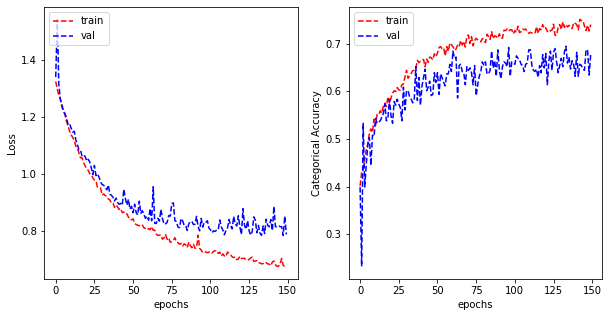

In [7]:
# model1 - no tuning just using HIDDEN_LAYER_DIM = 256 with no reg and dropout
# initialize layers
model1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

# compile model
model1.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

# fit model
history_model1 = model1.fit_generator(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

# plot model performance
plot_learning_curve(history_model1.history['loss'], history_model1.history['val_loss'], 
                    history_model1.history['categorical_accuracy'], history_model1.history['val_categorical_accuracy'], 
                    metric_name='Categorical Accuracy')

### Model2
1. HIDDEN_LAYER_DIM = 256
2. reg with lambda = 0.01
3. no dropout
4. sigmoid activation

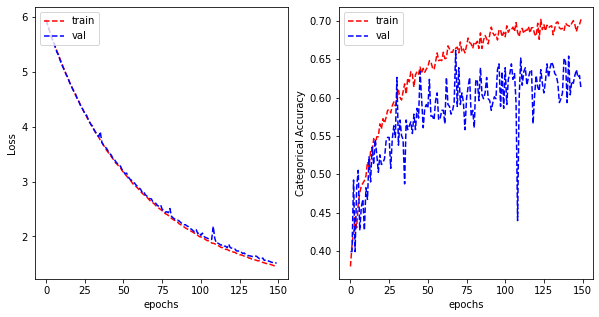

In [9]:
# model2
# initialize layers

reg_lambda = 0.01

model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

# compile model
model2.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

# fit model
history_model2 = model2.fit_generator(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

# plot model performance
plot_learning_curve(history_model2.history['loss'], history_model2.history['val_loss'], 
                    history_model2.history['categorical_accuracy'], history_model2.history['val_categorical_accuracy'], 
                    metric_name='Categorical Accuracy')

### Model3
1. HIDDEN_LAYER_DIM = 256
2. no reg
3. dropout .3
4. sigmoid activation

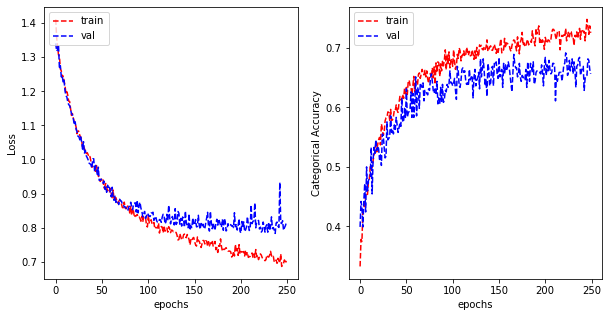

In [34]:
# model3
# initialize layers
model3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

# compile model
model3.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

# fit model
history_model3 = model3.fit_generator(train_generator, validation_data = validation_generator, epochs=100, verbose=0)

# plot model performance
plot_learning_curve(history_model3.history['loss'], history_model3.history['val_loss'], 
                    history_model3.history['categorical_accuracy'], history_model3.history['val_categorical_accuracy'], 
                    metric_name='Categorical Accuracy')

### Keras tuner

In [25]:
import kerastuner as kt
from tensorflow import keras
from tensorflow.keras import layers

# copy pasted from https://www.tensorflow.org/tutorials/keras/keras_tuner, will need to paraphrase
def model_builder(hp):
    # Selection ranges
    # Dense layer unit value
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    # Regularization lambda value
    hp_reg_lambdas = hp.Choice('reg_lambda', values=[0.001, 0.005, 0.01, 0.02, 0.05])
    # activation function choice
    hp_activations = hp.Choice('activation', values=['sigmoid', 'relu', 'softmax', 'tanh'])
    # dropout value
    hp_dropouts = hp.Float('dropout', min_value=0, max_value=0.5, step=0.1)
    
    # initialize layers
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=INPUT_DIM),
        tf.keras.layers.Dense(units=hp_units, activation=hp_activations, kernel_regularizer=tf.keras.regularizers.l2(hp_reg_lambdas)),
        tf.keras.layers.Dropout(hp_dropouts),
        tf.keras.layers.Dense(OUTPUT_CLASSES)
    ])
    
    # compile model
    model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

    return model

# Instantiate the tuner and perform hypertuning
tuner = kt.Hyperband(model_builder,
                     objective='val_categorical_accuracy',
                     max_epochs=150,
                     factor=3,
                     directory='keras_tuner_dir',
                     project_name='v5')

# Early stopping callback
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# extracting the image and labels from the generators as search function does not support generators directly
train_img,train_lables = train_generator.next()
val_img,val_lables = validation_generator.next()

In [26]:
# Execute search
tuner.search(train_img,train_lables,
             validation_data=(val_img,val_lables),batch_size = 32, callbacks=[stop_early])
# tuner.search(train_img,train_lables,
#              validation_data=(val_img,val_lables),batch_size = 32)

# Print optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
 units: {best_hps.get('units')}
 lamda: {best_hps.get('reg_lambda')}
 activation: {best_hps.get('activation')}
 dropout: {best_hps.get('dropout')}
""")

Trial 254 Complete [00h 00m 05s]
val_categorical_accuracy: 0.46875

Best val_categorical_accuracy So Far: 0.65625
Total elapsed time: 00h 05m 11s
INFO:tensorflow:Oracle triggered exit

 units: 288
 lamda: 0.05
 activation: tanh
 dropout: 0.2



### Model 4
Best params from keras tuner

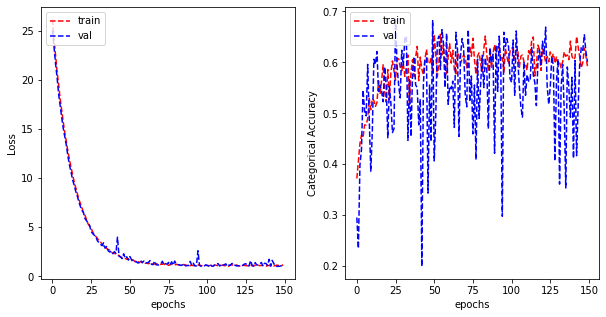

In [28]:
# model4
# initialize layers
model4 = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=INPUT_DIM),
        tf.keras.layers.Dense(units=best_hps.get('units'), activation=best_hps.get('activation'), kernel_regularizer=tf.keras.regularizers.l2(best_hps.get('reg_lambda'))),
        tf.keras.layers.Dropout(best_hps.get('dropout')),
        tf.keras.layers.Dense(OUTPUT_CLASSES)
    ])

# compile model
model4.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

# fit model
history_model4 = model4.fit_generator(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

# plot model performance
plot_learning_curve(history_model4.history['loss'], history_model4.history['val_loss'], 
                    history_model4.history['categorical_accuracy'], history_model4.history['val_categorical_accuracy'], 
                    metric_name='Categorical Accuracy')

## Testing the models
Testing the models with test set

In [29]:
# Initialize test generator
test_data['cellType'] = test_data['cellType'].astype('str')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
batch_size = 1
test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

test_img,test_labels = test_generator.next()

Found 396 validated image filenames belonging to 4 classes.


<ipython-input-29-531a6e9e795b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['cellType'] = test_data['cellType'].astype('str')


In [30]:
# Model 1
model1.evaluate(test_generator)

396/396 [==============================] - 1s 2ms/step - loss: 0.7668 - categorical_accuracy: 0.7045


[0.7667527794837952, 0.7045454382896423]

In [31]:
# Model 2
model2.evaluate(test_generator)

396/396 [==============================] - 1s 2ms/step - loss: 1.4755 - categorical_accuracy: 0.6591


[1.4754533767700195, 0.6590909361839294]

In [37]:
# Model 3
model3.evaluate(test_generator)

396/396 [==============================] - 1s 2ms/step - loss: 0.7716 - categorical_accuracy: 0.7121


[0.7716110944747925, 0.7121211886405945]

In [33]:
# Model 4
model4.evaluate(test_generator)

396/396 [==============================] - 1s 2ms/step - loss: 1.0406 - categorical_accuracy: 0.6414


[1.0406460762023926, 0.6414141654968262]